In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import random_split
import torch
import seaborn as sns
from tqdm import tqdm
from time import perf_counter

from nam.wrapper import NAMClassifierDistill, MultiTaskNAMClassifierDistill

C:\Users\satch\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random_state = 2016

In [46]:
from tensorflow import keras
# Load the CIFAR-10 dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data
train_images = train_images / 255.0
test_images = test_images / 255.0
train_images = train_images.reshape(-1, 28*28)
test_images = test_images.reshape(-1, 28*28)
train_images.shape

(60000, 784)

In [5]:
# binary = ['sex', 'c_charge_degree']
# other = ['age', 'race', 'priors_count', 'length_of_stay']

In [50]:
def select_dataset3(x, y, n1, n2, n3):
    mask = np.where((y==n1) | (y==n2) | (y==n3))
    return x[mask], y[mask]

def select_dataset2(x, y, n1, n2):
    mask = np.where((y==n1) | (y==n2))
    return x[mask], y[mask]

# train_images, train_labels = select_dataset3(train_images, train_labels, 0,1,2)
# test_images, test_labels = select_dataset3(train_images, train_labels, 0,1,2)
train_images, train_labels = select_dataset2(train_images, train_labels, 0,1)
test_images, test_labels = select_dataset2(train_images, train_labels, 0,1)
# train_labels
set(test_labels)

{0, 1}

In [51]:
train_images.shape

(12665, 784)

In [6]:
# scaler = MinMaxScaler((-1, 1))
# dataset[other] = scaler.fit_transform(dataset[other])
# dataset[binary] = dataset[binary] - 1

In [20]:
# dataset

In [8]:
# data_train, data_test = train_test_split(train_images, train_labels, train_size=0.8, test_size=0.2, random_state=random_state)
# X_train, y_train = data_train[other + binary], data_train['two_year_recid']
# X_test, y_test = data_test[other + binary], data_test['two_year_recid']

## Multitask NAMs Classification

In [53]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]


lim = None
train_labels_sub = to_categorical(train_labels,2)[:lim]
test_labels_sub = to_categorical(test_labels,2)[:lim]
train_images_sub = train_images[:lim]
test_images_sub = test_images[:lim]

test_labels_sub.shape

(12665, 2)

In [54]:
import torch

model = MultiTaskNAMClassifier(
            num_learners=1,
            patience=60,
            num_epochs=10,
            num_subnets=1,
            metric='accuracy',
            monitor_loss=True,
            early_stop_mode='max',
            n_jobs=1,
            random_state=random_state,
            loss_func=torch.nn.functional.cross_entropy
        )

start = perf_counter()
print("training")
model.fit(train_images_sub, train_labels_sub)
print(perf_counter()-start)

training


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:40<00:00,  8.47s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.21it/s]
Epoch(0):                                                                                                              
                    Training Loss: 75.244 |
Epoch(0):           Validation Loss: 4.755 | ACCURACY: 0.254:   0
                    Training Loss: 75.244 |
                    Validation Loss: 4.755 | ACCURACY: 0.254:  10
100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:50<00:00,  9.54s/it]
                                                                                                                       
100%|███████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [02:01<00:00, 10.25s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]
Epoch(7):                                                                                                              
                    Training Loss: 0.024 |
Epoch(7):           Validation Loss: 0.018 | ACCURACY: 0.496:  70%
                    Training Loss: 0.024 |
                    Validation Loss: 0.018 | ACCURACY: 0.496:  80%
100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [02:01<00:00, 10.13s/it]
                                                                                                                       
100%|███████████████████████████████████████████████████████

1197.5495561000425


In [195]:
model._fitted=True

In [55]:
model.models[0].eval()
pred = torch.nn.functional.softmax(torch.tensor(model.predict_proba(test_images_sub[:100])))
# sk_metrics.roc_auc_score(test_labels, pred)
np.argmax(pred, axis=-1)
# pred

C:\Users\satch\AppData\Local\Temp\ipykernel_6644\3552509995.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.softmax(torch.tensor(model.predict_proba(test_images_sub[:100])))


tensor([0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 1])

In [56]:
pred_labels = np.argmax(pred, axis=-1)
len(pred_labels)

100

In [57]:
print(set([x.item() for x in pred_labels]))

{0, 1}


In [58]:
test_labels_sub_labels = np.argmax(test_labels_sub[:100], axis=-1)

np.mean(pred_labels.detach().numpy()==test_labels_sub_labels[:100])

0.98

C:\Users\satch\Desktop\MSc Artificial Intelligence\IEinAI\Week 4\GitHub\nam\nam\wrapper\wrapper.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, requires_grad=False, dtype=torch.float)


1


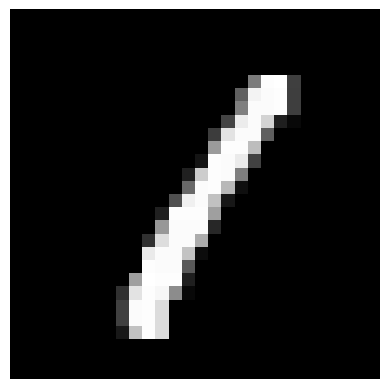

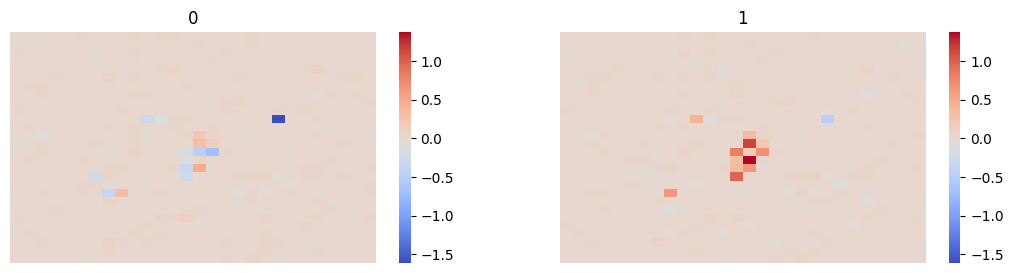

<BarContainer object of 2 artists>

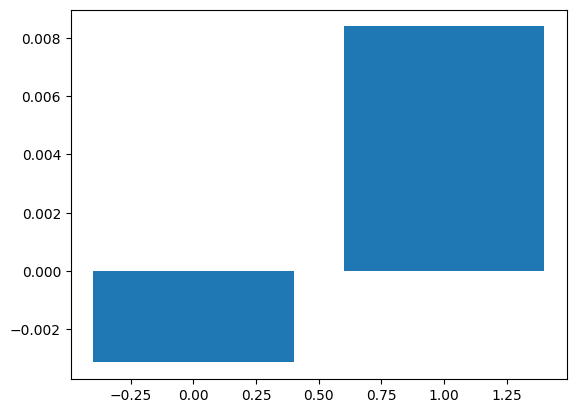

In [59]:
preds = []
idx=1
# model.dropout=0
# model.feature_dropout=0
# model.dropout_layer = torch.nn.Dropout(p=0)

# np.random.seed()
# torch.random.seed()

# for i in range(784):
#     model.models[0].feature_nns[i].dropout = torch.nn.Dropout(p=0)

model.models[0].eval()

X = torch.tensor([test_images[idx]], requires_grad=False, dtype=torch.float)
# for single_model in model.models:
#     preds.append(single_model.calc_outputs(X))
preds = model.models[0].calc_outputs(X)
label_pred = model.predict_proba(X)
print(np.argmax(label_pred))

preds = [x.squeeze().detach().numpy() for x in preds]

preds = np.array(preds)
preds = preds.T

image = test_images[idx].reshape(28,28)
plt.imshow(image, cmap="gray")
plt.axis("off")

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(13,3))
axs = axs.flatten()

vmax = np.max(preds)
vmin = np.min(preds)
means = []
for i in range(2):
    image_importance = preds[i].reshape(28,28) 
    means.append(np.mean(image_importance))
    most_important_idx = np.argmax(np.array([x.item() for x in preds[0]]))
    #image_importance[abs(image_importance) < 0.08] = 0

#     sns.heatmap(image, cmap="gray", ax=axs[0])
    sns.heatmap(image_importance, cmap="coolwarm", ax=axs[i], vmin=vmin, vmax=vmax)

#     axs[0].axis("off")
    axs[i].axis("off")
    axs[i].set_title(i)
    
plt.show()
plt.bar(np.arange(0,2), means)

In [219]:
# model.models[0].save("epoch38_single_nam.h5")
# print(model.models[0]._bias.detach().numpy().squeeze())

# from nam.models.saver import Checkpointer

# checkpointer = Checkpointer(log_dir="output_long/0") # only one model
# checkpointer.save(model.models[0], "best")

IndexError: list index out of range

### Loading saved checkpoint

In [223]:
# model = MultiTaskNAMClassifier(
#             num_learners=1,
#             patience=60,
#             num_epochs=100,
#             num_subnets=1,
#             metric='accuracy',
#             monitor_loss=True,
#             early_stop_mode='max',
#             n_jobs=1,
#             random_state=random_state,
#             loss_func=torch.nn.functional.cross_entropy
#         )

# model.load_checkpoints("output_long")

# model.models[0].eval()
# pred = torch.nn.functional.softmax(torch.tensor(model.predict_proba(test_images_sub[:100])))
# test_labels_sub_labels = np.argmax(test_labels_sub[:100], axis=-1)
# np.mean(pred_labels.detach().numpy()==test_labels_sub_labels[:100])

C:\Users\satch\AppData\Local\Temp\ipykernel_11456\3249629709.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.softmax(torch.tensor(model.predict_proba(test_images_sub[:100])))


0.34

In [60]:
preds.shape

(2, 784)

In [61]:
activations = []
test_idx = most_important_idx

test_image = np.zeros(test_images[idx].shape)

for i in tqdm(range(255)):
    i/=255
    test_image[:] = i
    X = torch.tensor([test_image], requires_grad=False, dtype=torch.float)
    for single_model in model.models:
        model_out = single_model.calc_outputs(X)
        model_out = np.array([x.detach().numpy().squeeze() for x in model_out])
        activations.append(model_out)

100%|████████████████████████████████████████████████████████████████████████████████| 255/255 [01:18<00:00,  3.25it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.82it/s]


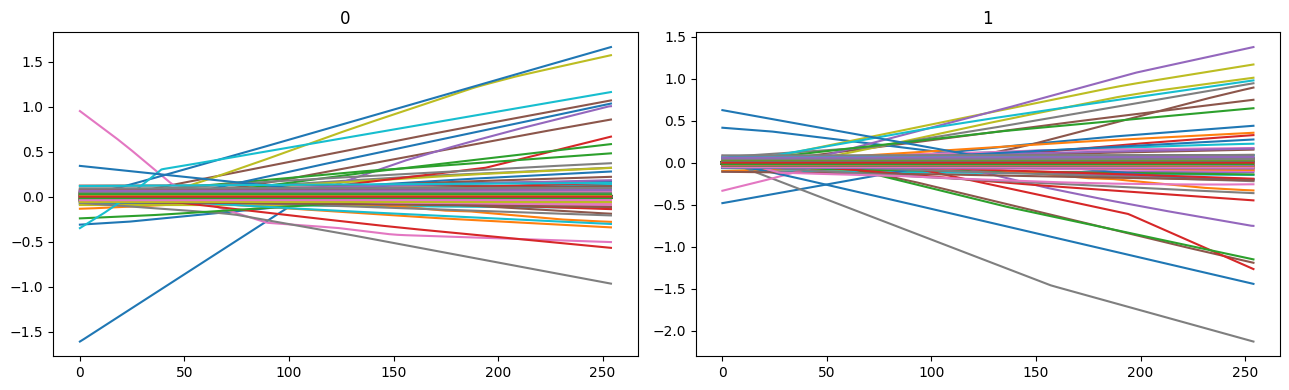

In [62]:
activations = np.array(activations)
activations_reshaped = activations.transpose((2,0,1))

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(13,4))
axs = axs.flatten()

for i in tqdm(range(2)):
    axs[i].set_title(i)
    for act in activations_reshaped[i].T:
        axs[i].plot(act)

plt.tight_layout()
# activations_reshaped[0]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.15it/s]


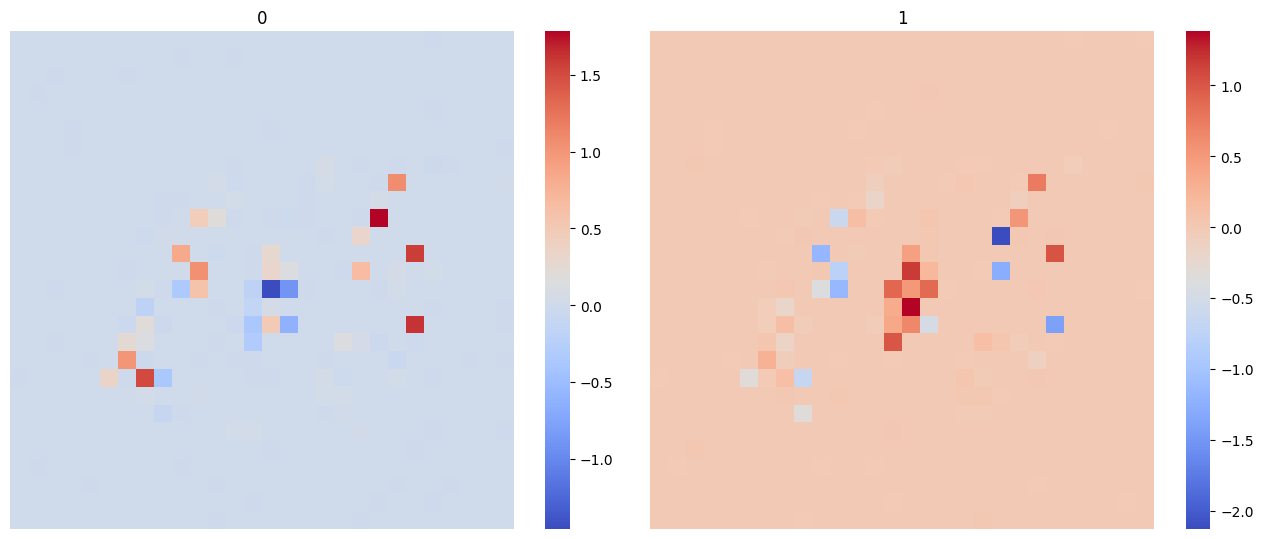

In [67]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(13,5.5))
axs = axs.flatten()


vmin=np.min(activations_reshaped)
vmax=np.max(activations_reshaped)

vmax = abs(max(vmin, vmax))
vmin = -vmax

for i in tqdm(range(2)):
    axs[i].set_title(i)
    actT = activations_reshaped[i].T
#     cols = np.std(actT, axis=1)
#     cols = np.max(actT, axis=1)-np.min(actT[:], axis=1)
    cols = actT[:,-1]-actT[:,0]
#     cols[cols>0.33]=1
#     cols[cols<=0.33]=0
#     sns.heatmap(cols.reshape(28,28), ax=axs[i], vmin=vmin, vmax=vmax, cmap="coolwarm")
    sns.heatmap(cols.reshape(28,28), ax=axs[i], cmap="coolwarm")
    axs[i].axis("off")
plt.tight_layout()

